In [84]:
from src.models import KAN, MLP
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [85]:
# 定义数据转换
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# 加载训练集和测试集
train_dataset = datasets.MNIST(
    root="./dataset", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./dataset", train=False, download=True, transform=transform
)

# 定义数据加载器
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=1000, shuffle=False
)

In [89]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [87]:
def train(model, train_loader, test_loader, total_test_samples):
    epochs = 50

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(epochs):
        model.train()

        running_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred_test = model(X_batch)
                loss = criterion(y_pred_test, y_batch)
                test_loss += loss.item()

                pred = y_pred_test.argmax(dim=1, keepdim=True).squeeze()
                correct += pred.eq(y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        accuracies.append(correct / total_test_samples)

    return train_losses, test_losses, accuracies

In [88]:
mlp = MLP(28 * 28, [256, 64], 10)
mlp_train_losses, mlp_test_losses, mlp_accuracies = train(
    mlp, train_loader, test_loader, total_test_samples=len(test_dataset)
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 784x256)

In [ ]:
kan = KAN([28 * 28, 64, 10])
kan_train_losses, kan_test_losses, kan_accuracies = train(
    kan, train_loader, test_loader, total_test_samples=len(test_dataset)
)

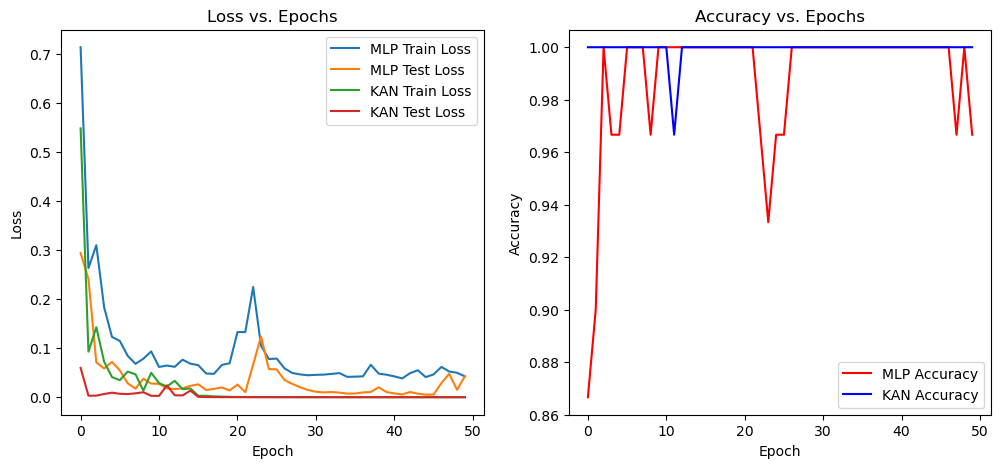

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp_train_losses, label="MLP Train Loss")
plt.plot(mlp_test_losses, label="MLP Test Loss")
plt.plot(kan_train_losses, label="KAN Train Loss")
plt.plot(kan_test_losses, label="KAN Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_accuracies, label="MLP Accuracy", color="r")
plt.plot(kan_accuracies, label="KAN Accuracy", color="b")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()